In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet101

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [21]:
train_path = '/home/ds20/Downloads/Data Main/train'
test_path = '/home/ds20/Downloads/Data Main/test'

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [25]:
size_images = 150
batch_size = 32

In [26]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 31571 images belonging to 4 classes.


In [28]:
labels_count = train_generator.classes
labels_count

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

/tmp/ipykernel_7909/3959620350.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=45, ha='right')


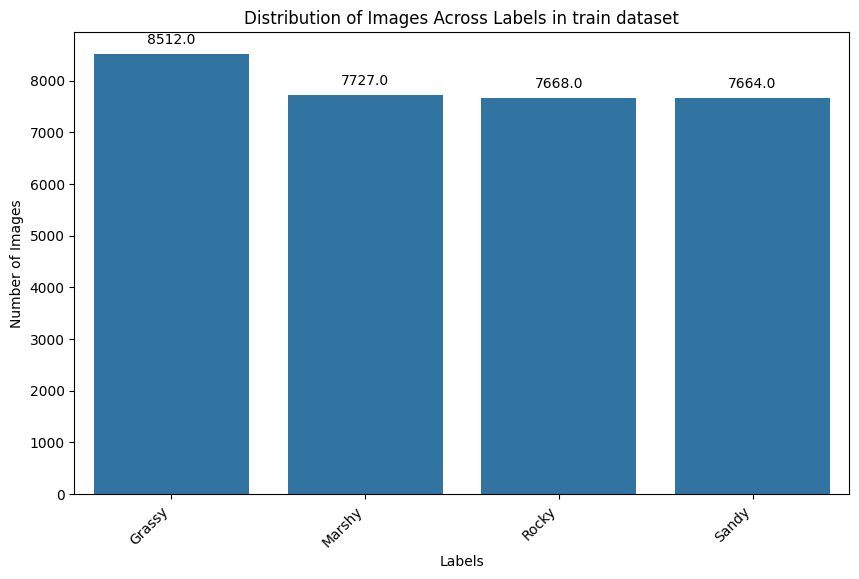

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_generator' is your image data generator
labels_count = train_generator.classes
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_count)
plt.title('Distribution of Images Across Labels in train dataset')
plt.xlabel('Labels')
plt.ylabel('Number of Images')

# Add the count on top of each bar
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add class names below the bars
ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.show()

In [32]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [33]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 6769 images belonging to 4 classes.


/tmp/ipykernel_7909/1988738420.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=45, ha='right')


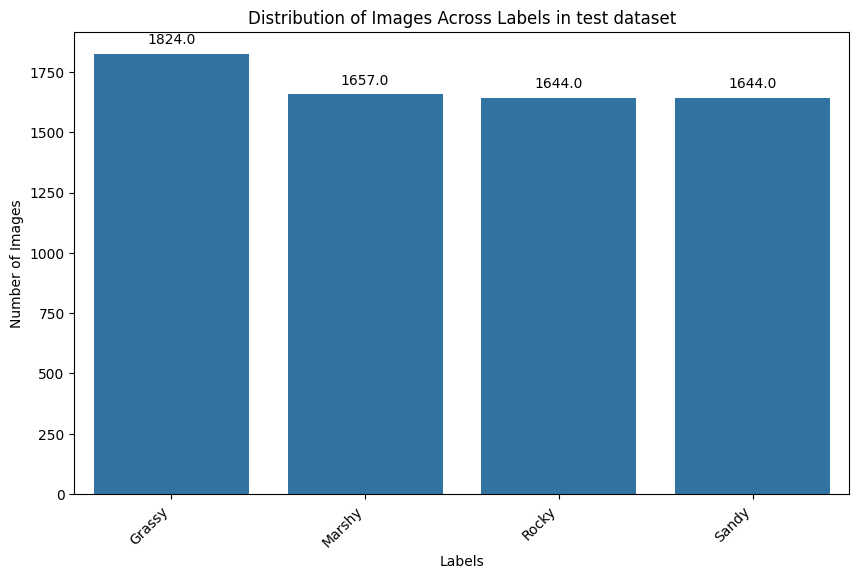

In [34]:
# Assuming 'train_generator' is your image data generator
labels_count = test_generator.classes
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_count)
plt.title('Distribution of Images Across Labels in test dataset')
plt.xlabel('Labels')
plt.ylabel('Number of Images')

# Add the count on top of each bar
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add class names below the bars
ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.show()

In [38]:
def Show_Images(target_gen):
    # Get a batch of images and labels
    batch_images, batch_labels = next(target_gen)

    # Get class labels
    class_labels = list(target_gen.class_indices.keys())

    # Display images with labels
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])  # Display the class label
        plt.axis('off')
    plt.show()

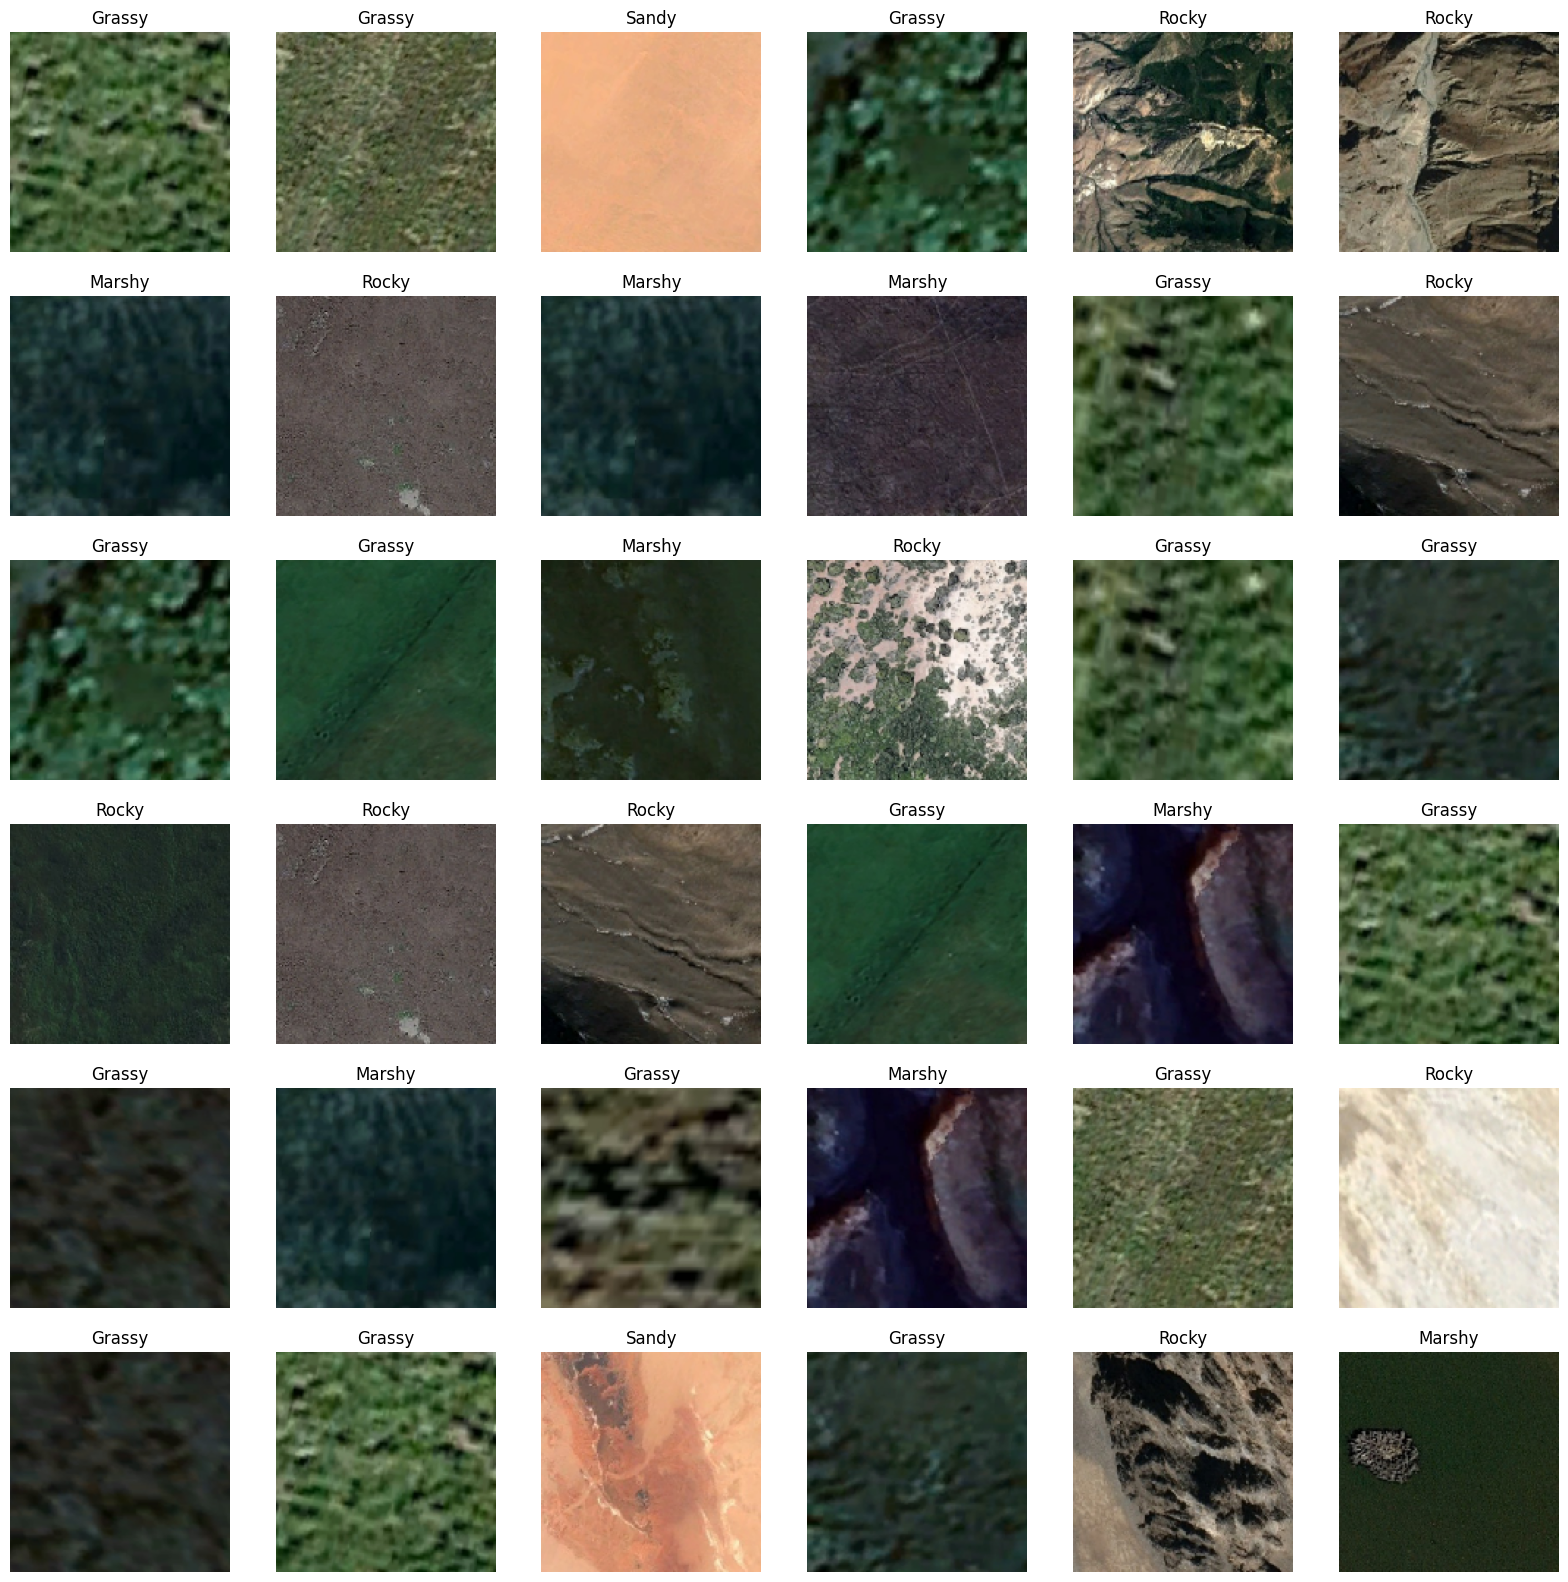

In [36]:
Show_Images(test_generator)

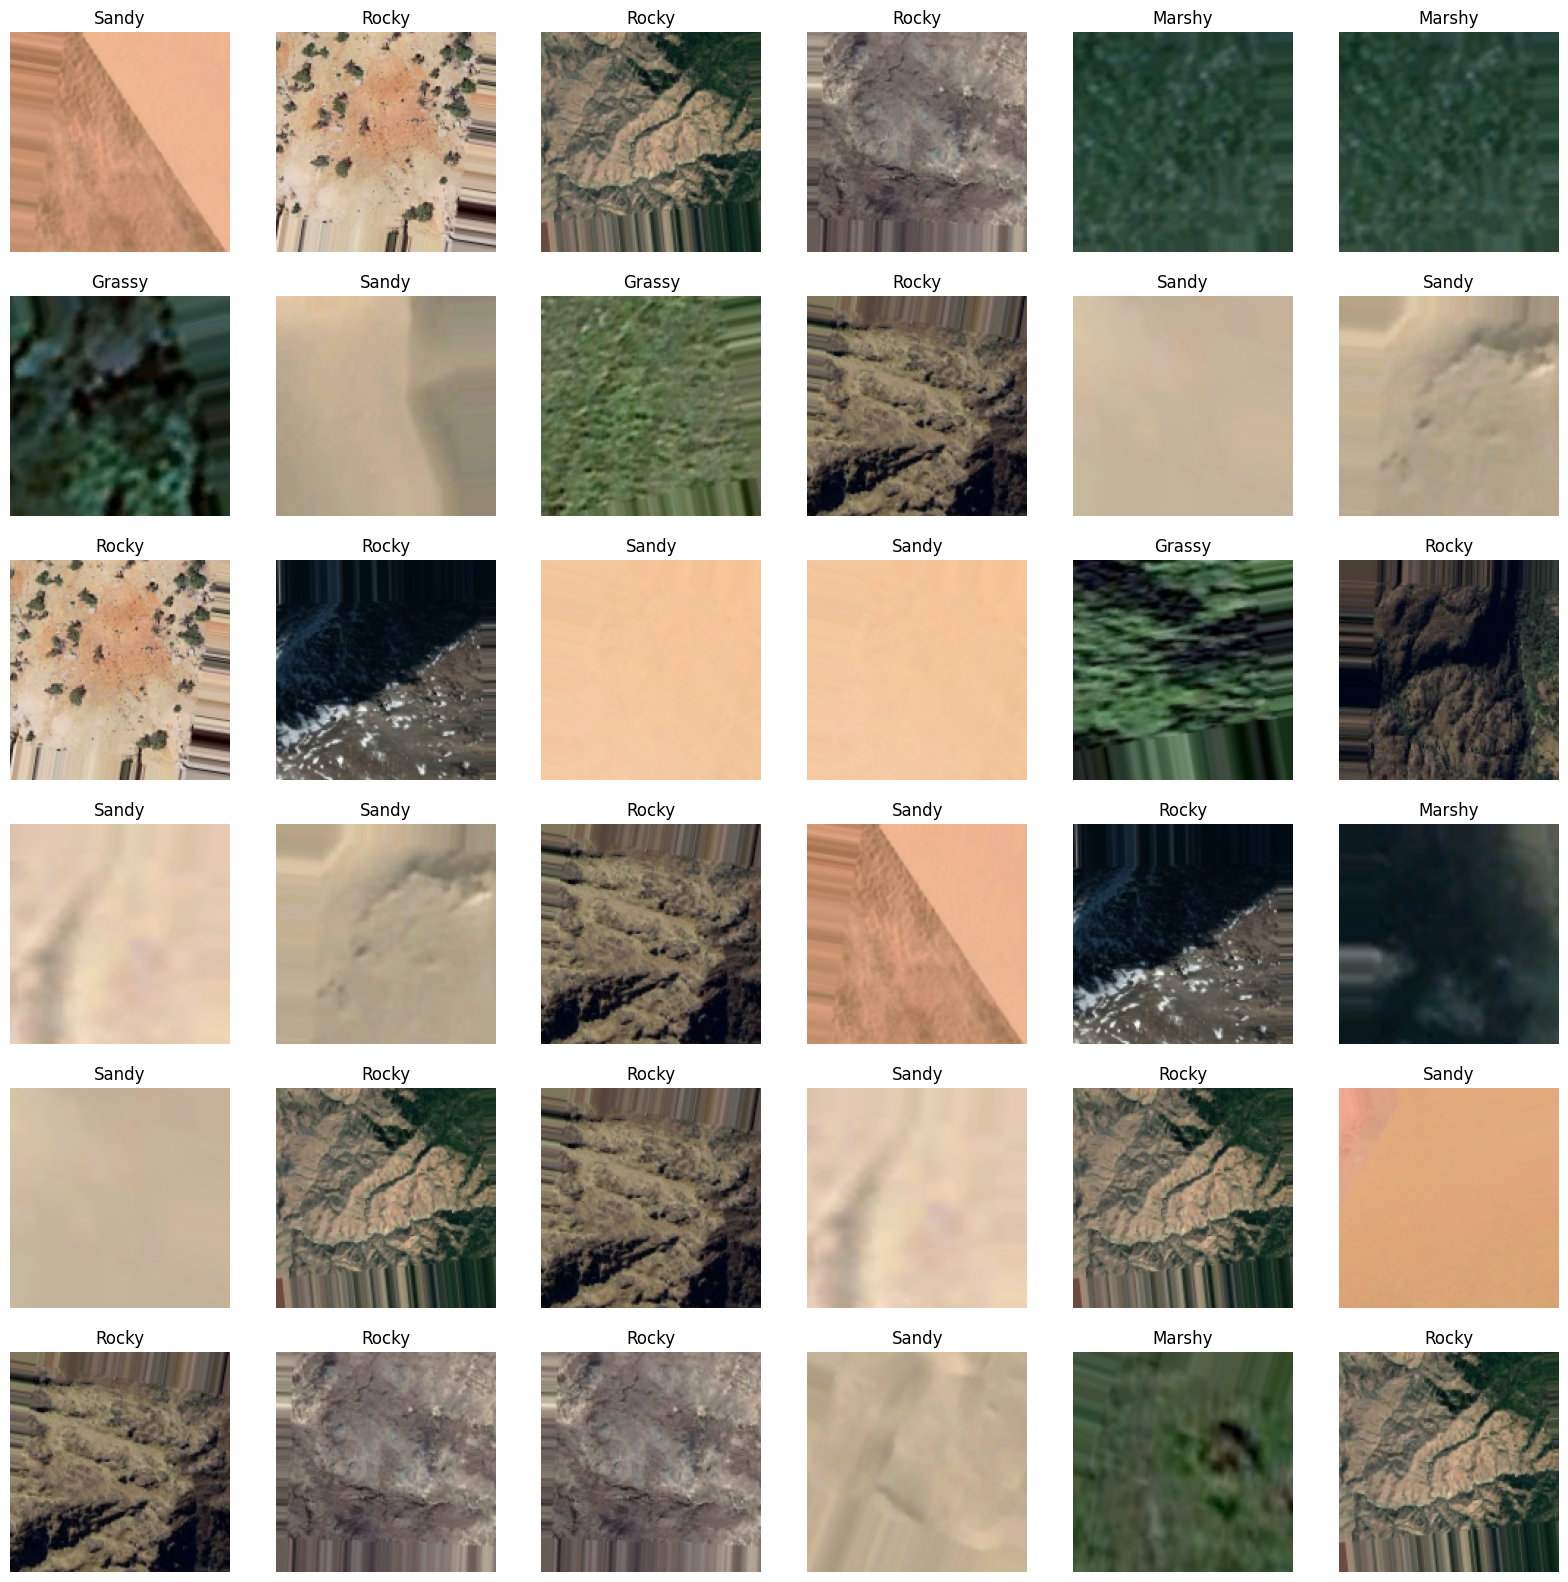

In [37]:
Show_Images(train_generator)

In [39]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)


In [40]:
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [41]:
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

/tmp/ipykernel_7909/527549765.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))
2024-04-24 10:09:39.101103: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 10:09:39.112533: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required librarie

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [42]:
for layer in base_model.layers:
    layer.trainable = False

In [43]:
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
    base_model,
    
    layers.Flatten(),
    
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6,activation='softmax'),
])

In [45]:
initial_learning_rate = 0.1     # Initial learning rate
decay_steps = 1000              # Number of steps before decaying the learning rate
decay_rate = 0.5                # Rate at which the learning rate decays
staircase = True                # Whether to use staircase decay (integer division of step by decay_steps)

# Create the exponential decay schedule
def lr_schedule(epoch, lr):
    if staircase:
        return lr * decay_rate ** (epoch // decay_steps)
    else:
        return lr * decay_rate ** (epoch / decay_steps)

In [46]:
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [53]:
from keras.callbacks import LearningRateScheduler

def lr_schedule_wrapper(epoch, lr):
    return lr_schedule(epoch, lr)

# Create the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_schedule)
callback=[early_stopping , learning_rate_reduce , lr_callback]

In [54]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule_wrapper),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)


In [55]:
from tensorflow.keras.layers import Dense

# Get the model architecture up to the last layer
model = tf.keras.Sequential(model.layers[:-1])

# Add a new output layer for 4 classes
new_output = Dense(4, activation='softmax')  # Assuming 4 classes
model.add(new_output)  # Add the new output layer

# Compile the model again after modifying the architecture
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
    
)

Epoch 1/15


/home/ds20/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


986/986 ━━━━━━━━━━━━━━━━━━━━ 111s 111ms/step - accuracy: 0.7576 - loss: 0.6996 - val_accuracy: 0.8943 - val_loss: 0.2717 - learning_rate: 0.0010
Epoch 2/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 0s 53us/step - accuracy: 0.8438 - loss: 0.5134 - val_accuracy: 0.8824 - val_loss: 0.2697 - learning_rate: 0.0010
Epoch 3/15


/home/ds20/.local/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
2024-04-24 10:35:02.229598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-04-24 10:35:02.253443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


986/986 ━━━━━━━━━━━━━━━━━━━━ 110s 111ms/step - accuracy: 0.8955 - loss: 0.3019 - val_accuracy: 0.9197 - val_loss: 0.2060 - learning_rate: 0.0010
Epoch 4/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.9688 - loss: 0.1076 - val_accuracy: 0.9412 - val_loss: 0.1331 - learning_rate: 0.0010
Epoch 5/15


2024-04-24 10:36:52.317302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 10:36:52.339162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


986/986 ━━━━━━━━━━━━━━━━━━━━ 110s 111ms/step - accuracy: 0.9179 - loss: 0.2389 - val_accuracy: 0.9385 - val_loss: 0.1670 - learning_rate: 0.0010
Epoch 6/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.9375 - loss: 0.1365 - val_accuracy: 0.9412 - val_loss: 0.1738 - learning_rate: 0.0010
Epoch 7/15


2024-04-24 10:38:42.488856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 10:38:42.510765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


986/986 ━━━━━━━━━━━━━━━━━━━━ 110s 111ms/step - accuracy: 0.9300 - loss: 0.2129 - val_accuracy: 0.9458 - val_loss: 0.1549 - learning_rate: 0.0010
Epoch 8/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.9375 - loss: 0.2069 - val_accuracy: 0.9412 - val_loss: 0.1128 - learning_rate: 0.0010
Epoch 9/15


2024-04-24 10:40:32.576507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 10:40:32.599198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


986/986 ━━━━━━━━━━━━━━━━━━━━ 110s 111ms/step - accuracy: 0.9392 - loss: 0.1803 - val_accuracy: 0.9439 - val_loss: 0.1742 - learning_rate: 0.0010
Epoch 10/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.9062 - loss: 0.1688 - val_accuracy: 0.8824 - val_loss: 0.1936 - learning_rate: 0.0010
Epoch 11/15


2024-04-24 10:42:22.438648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 10:42:22.456643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


986/986 ━━━━━━━━━━━━━━━━━━━━ 109s 110ms/step - accuracy: 0.9449 - loss: 0.1676 - val_accuracy: 0.9461 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 12/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 0s 41us/step - accuracy: 0.9375 - loss: 0.2564 - val_accuracy: 1.0000 - val_loss: 0.0551 - learning_rate: 0.0010
Epoch 13/15


2024-04-24 10:44:11.942481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 10:44:11.960715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


986/986 ━━━━━━━━━━━━━━━━━━━━ 110s 111ms/step - accuracy: 0.9463 - loss: 0.1649 - val_accuracy: 0.9461 - val_loss: 0.1654 - learning_rate: 0.0010
Epoch 14/15
986/986 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 1.0000 - loss: 0.0385 - val_accuracy: 1.0000 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 15/15


2024-04-24 10:46:01.748917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-24 10:46:01.767423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


986/986 ━━━━━━━━━━━━━━━━━━━━ 110s 111ms/step - accuracy: 0.9526 - loss: 0.1435 - val_accuracy: 0.9545 - val_loss: 0.1291 - learning_rate: 0.0010


In [58]:
model.save('/home/ds20/Miniproject/model.keras')

212/212 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step
Classification Report:
              precision    recall  f1-score   support

      Grassy       0.27      0.28      0.27      1824
      Marshy       0.22      0.21      0.22      1657
       Rocky       0.25      0.24      0.24      1644
       Sandy       0.25      0.25      0.25      1644

    accuracy                           0.25      6769
   macro avg       0.25      0.25      0.25      6769
weighted avg       0.25      0.25      0.25      6769



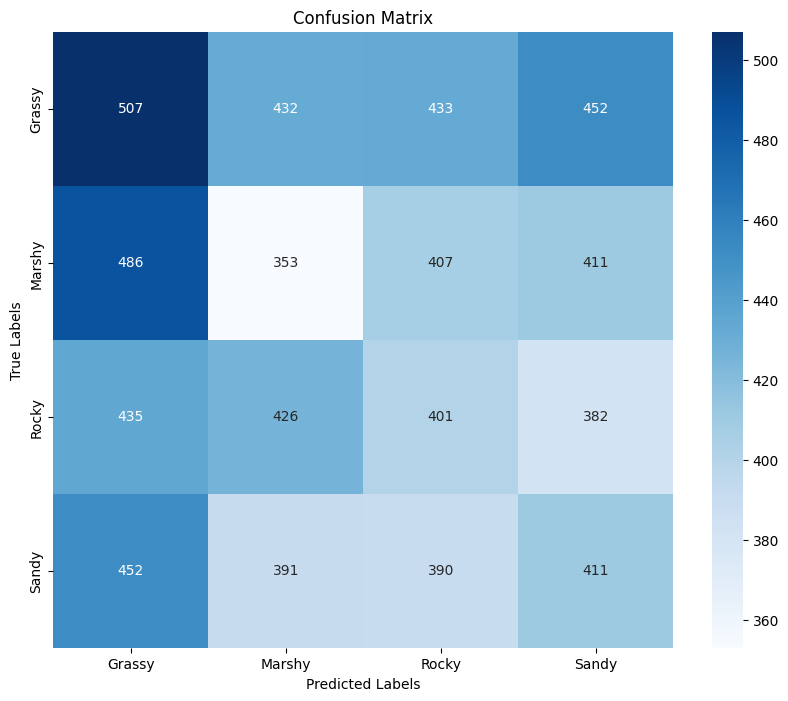

In [60]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
loaded_model = load_model('/home/ds20/Miniproject/model.keras')

# Assuming 'test_generator' is your test data generator
predictions = loaded_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [61]:
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14294449985027313
Test accuracy: 0.9479982256889343


<Figure size 640x480 with 0 Axes>

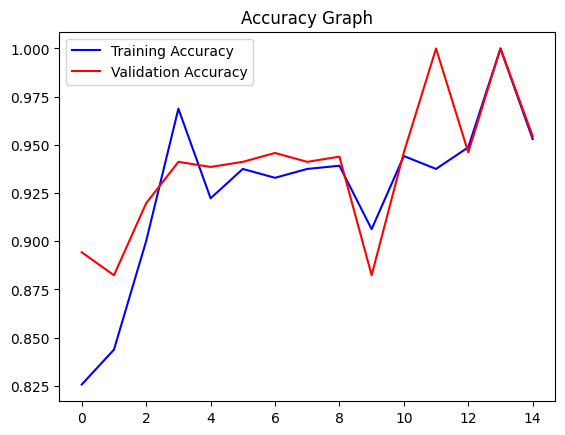

<Figure size 640x480 with 0 Axes>

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

In [63]:
base_model.summary

<bound method Model.summary of <Functional name=mobilenet_1.00_224, built=True>>

In [87]:
import numpy as np
from keras.preprocessing import image
img_path = '/home/ds20/Downloads/Data Main/val/Sandy/Sandy (7)_9_30.png'
img = image.load_img(img_path, target_size=(150, 150))  # Set target_size to the dimensions used during training

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand the dimensions of the image to match the input shape of the model
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (e.g., rescale pixel values)
img_array = img_array / 255.0  # Assuming rescaling was done during training

# Make predictions
predictions = loaded_model.predict(img_array)

# Interpret the predictions (e.g., convert probabilities to class labels)
# Assuming predictions is a one-hot encoded array
predicted_class = np.argmax(predictions)
dic = {0:'Grassy',1:'Marshy',2:'Rocky',3:'Sandy'}
print("Predicted class:", dic[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted class: Sandy
